# Clustering de imágenes de OCT

Clustering de imágenes de Tomografía de Coherencia Óptica (OCT). Las imágenes muestran cortes de la retina de pacientes con diversas patologías y sanos.

**Datos**

Vectores de embedding de las imágenes generados por una ResNet50, previamente entrenada para la detección de una patología en las imágenes.
- ResNet50: tamaño del embedding -> 2048.

In [ ]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

from PIL import Image
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, HDBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

## 1. Cargar los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
csv = "embeddings_vitl16.csv"
data_path = "/content/drive/MyDrive/OCT/data/"
imgs_path = "/content/drive/MyDrive/OCT/data/images/"

In [ ]:
data = pd.read_csv(os.path.join(data_path, csv))
data.head()

Mostrar 8 imágenes aleatoriamente en resolución 256 x 256

In [ ]:
examples_imgs = data['image'].sample(8).tolist()
img_res = (256, 256)

fig, ax = plt.subplots(2, 4, figsize=(14, 8))
for ax, img_path in zip(ax.flatten(), examples_imgs):
    img = Image.open(os.path.join(imgs_path, img_path)).resize(img_res)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle('Sample OCT Images', fontsize=16)
plt.tight_layout()
plt.show()

# Tomografía de Coherencia Óptica
Estas imágenes corresponden a escaneos de **Tomografía de Coherencia Óptica** (OCT, por sus siglas en inglés) de la retina humana.

OCT (Optical Coherence Tomography) es una técnica de imagen médica no invasiva que utiliza ondas de luz para tomar fotografías de la sección transversal de la retina.

Es análogo a una ecografía, pero usa luz en lugar de sonido, lo que permite ver las distintas capas de tejido con una resolución muy alta.

Las imágenes corresponden a cortes transversales de la retina, el tejido sensible a la luz que recubre la parte posterior del ojo.

La depresión o "valle" que se ve en el centro de varias de las imágenes corresponde a la **fóvea**, que es el punto de mayor agudeza visual en el ojo.

Estas imágenes muestran diferentes estados de salud ocular, incluyendo ejemplos normales o "sanos", en los que se ven capas ordenadas, planas y continuas con la depresión foveal suave en el centro, y ejemplos asociados a diferentes patologías.

En caso de enfermedad, las imágenes pueden mostrar signos claros de diferentes enfermedades retinianas comunes, como por ejemplo:

* Drusas (Drusen): Pequeñas acumulaciones de desechos debajo de la retina (se ven como "bultos" u ondulaciones en las capas inferiores). Es un signo de Degeneración Macular Asociada a la Edad (DMAE).

* Edema Macular (DME): Acumulación de líquido. Se manifiesta como espacios negros o "quistes" dentro de las capas de la retina (zonas oscuras y huecas).

* Neovascularización Coroidea (CNV): Crecimiento anormal de vasos sanguíneos, que desorganiza completamente las capas y crea formas irregulares.

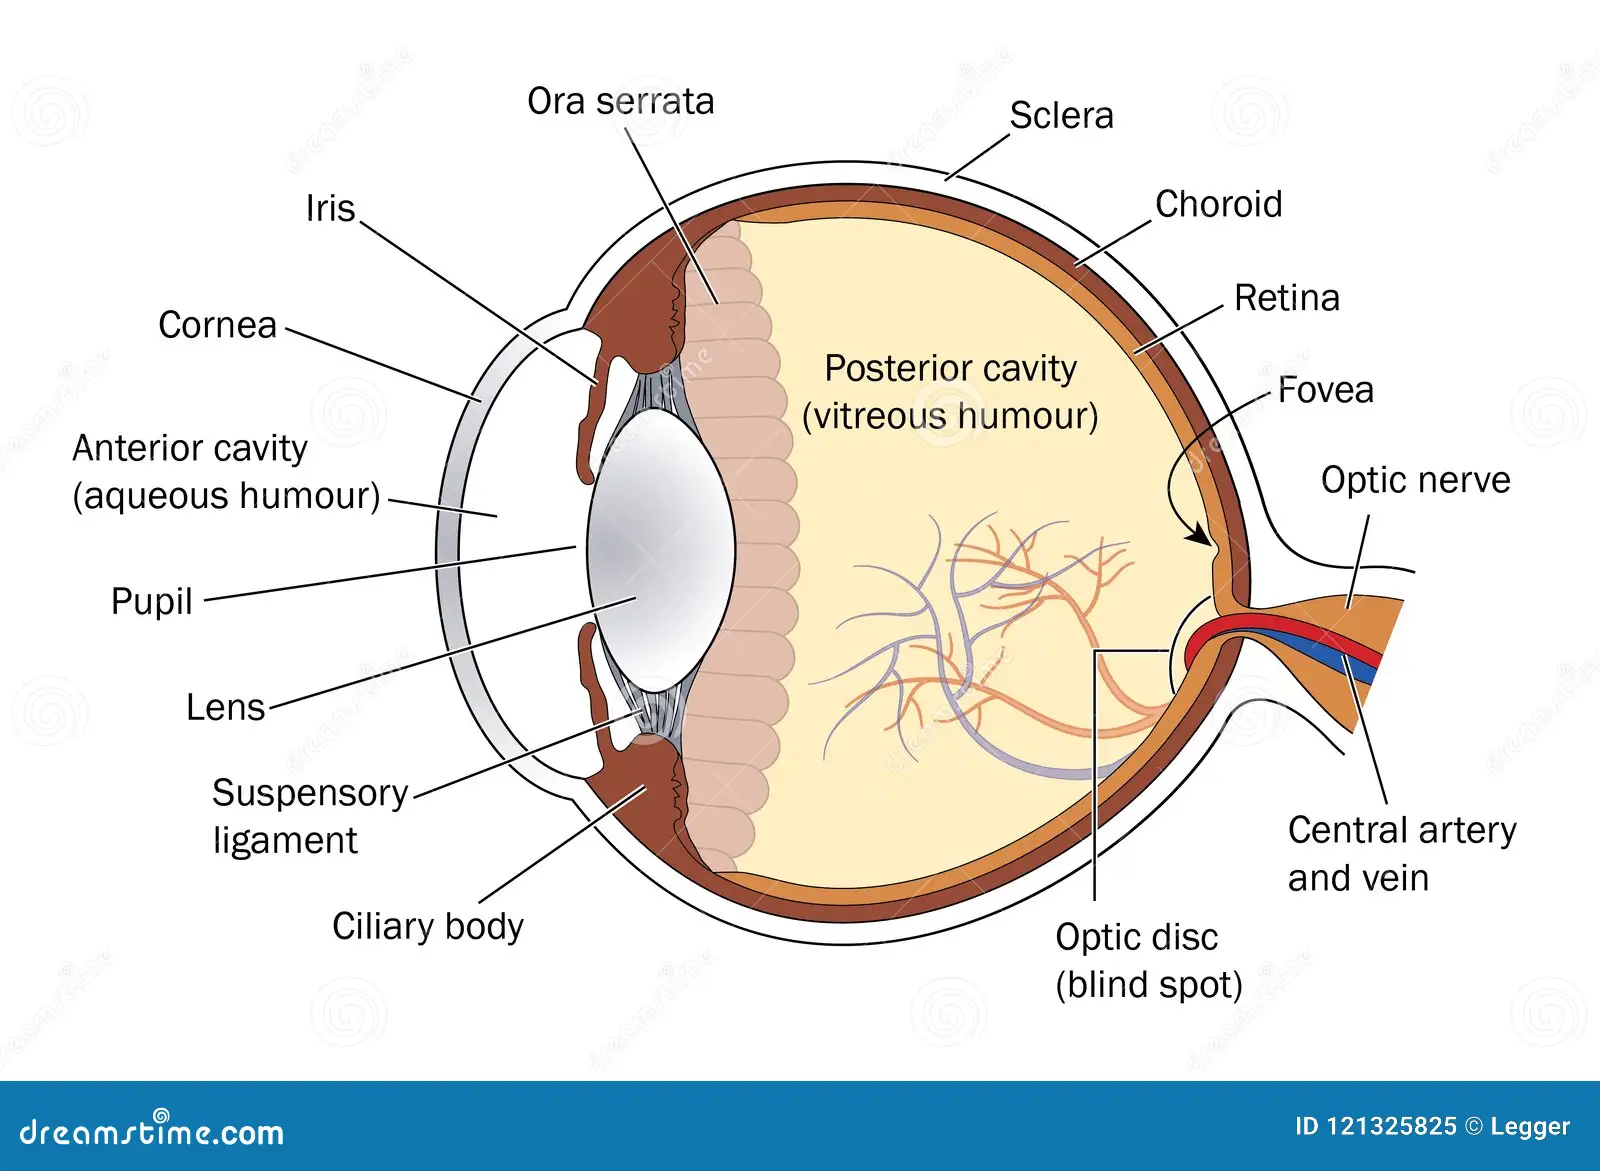

### 1.1 Escalado

In [ ]:
# Eliminar la columna 'path' para obtener solo las características
X = data.drop(['image'], axis=1).values

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. PCA

### 2.1 PCA 2D

In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig = go.Figure(data=go.Scatter(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    mode='markers',
    marker=dict(size=5),
    text=data['image'],
    hoverinfo='text'
))

fig.update_layout(
    title=f'PCA - Explained Variance: {pca_2d.explained_variance_ratio_.sum():.2%}',
    xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})',
    yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})',
    hovermode='closest',
    width=900,
    height=700
)

fig.show()

### 2.2 PCA 3D

In [ ]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = go.Figure(data=go.Scatter3d(
    x=X_pca_3d[:, 0],
    y=X_pca_3d[:, 1],
    z=X_pca_3d[:, 2],
    mode='markers',
    marker=dict(size=4),
    text=data['image'],
    hoverinfo='text'
))
fig.update_layout(
    title=f'PCA 3D - Explained Variance: {pca_3d.explained_variance_ratio_.sum():.2%}',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})'
    ),
    hovermode='closest',
    width=900,
    height=700
)
fig.show()

## 3. Clustering en espacio original

### 3.1 Clustering Aglomerativo Jerárquico (HAC)

In [ ]:
n_clusters = 3
hac_orig_space = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
y_hac_org_space = hac_orig_space.fit_predict(X_scaled)

print(f"HAC-completo con {n_clusters} cluters:\n")
print("Silhouette Score:", silhouette_score(X, y_hac_org_space))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, y_hac_org_space))

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    mode='markers',
    marker=dict(size=5, color=y_hac_org_space, colorscale='turbo', showscale=True, colorbar=dict(title='Cluster')),
    text=data['image'],
    hoverinfo='text'
))

fig.update_layout(
    title=f'PCA - Explained Variance: {pca_2d.explained_variance_ratio_.sum():.2%}',
    xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})',
    yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})',
    hovermode='closest',
    width=900,
    height=700
)

fig.show()

## 4. Clustering en espacio reducido

### 4.1 Clustering Aglomerativo Jerárquico (HAC) - 2D

In [ ]:
n_clusters = 3
hac_2d_space = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
y_hac_2d_space = hac_2d_space.fit_predict(X_pca_2d)

print(f"HAC-completo con {n_clusters} cluters:\n")
print("Silhouette Score:", silhouette_score(X_pca_2d, y_hac_2d_space))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_pca_2d, y_hac_2d_space))

In [ ]:
fig = go.Figure(data=go.Scatter(
    x=X_pca_2d[:, 0],
    y=X_pca_2d[:, 1],
    mode='markers',
    marker=dict(size=5, color=y_hac_2d_space, colorscale='turbo', showscale=True, colorbar=dict(title='Cluster')),
    text=data['image'],
    hoverinfo='text'
))

fig.update_layout(
    title=f'PCA - Explained Variance: {pca_2d.explained_variance_ratio_.sum():.2%}',
    xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})',
    yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})',
    hovermode='closest',
    width=900,
    height=700
)

fig.show()

### 4.2 Clustering Aglomerativo Jerárquico (HAC) - 3D

In [ ]:
n_clusters = 3
hac_3d_space = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
y_hac_3d_space = hac_2d_space.fit_predict(X_pca_3d)

print(f"HAC-completo con {n_clusters} cluters:\n")
print("Silhouette Score:", silhouette_score(X_pca_3d, y_hac_3d_space))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_pca_3d, y_hac_3d_space))

In [ ]:
fig = go.Figure(data=go.Scatter3d(
    x=X_pca_3d[:, 0],
    y=X_pca_3d[:, 1],
    z=X_pca_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=y_hac_3d_space, colorscale='turbo', showscale=True, colorbar=dict(title='Cluster')),
    text=data['image'],
    hoverinfo='text'
))
fig.update_layout(
    title=f'PCA 3D - Explained Variance: {pca_3d.explained_variance_ratio_.sum():.2%}',
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})'
    ),
    hovermode='closest',
    width=900,
    height=700
)
fig.show()

# 5. Estudio propio

**Silhouette**

Mide para cada punto qué tan bien está dentro de su cluster comparado con los demás clusters (cohesión vs separación).​

Toma valores entre ‑1 y 1:
*   ≈ 1 → punto muy bien asignado.

* ≈ 0 → en la frontera entre dos clusters.

* < 0 → probablemente mal asignado.

Se suele usar la media global: cuanto más alta, mejor clustering.​

**Calinski‑Harabasz (CH)**

Índice basado en el cociente entre la varianza entre clusters y la varianza dentro de los clusters.​

Intuición: quiere clusters compactos (baja dispersión interna) y bien separados entre sí (alta dispersión entre clusters).​

Cuanto mayor es el valor CH, mejor es la estructura de clusters.​

**Davies‑Bouldin (DB)**

Para cada cluster mira cuán disperso es y qué tan cerca está de su cluster más parecido; luego promedia sobre todos.​

Resultado ≥ 0:

Cercano a 0 → clusters compactos y bien separados (bueno).​

Valores altos → clusters solapados y/o muy dispersos (malo).​

## **PCA + DBSCAN + GMM - Pipeline Optimizado**

In [ ]:
# PCA PREVIO (100 componentes)
print("1️⃣ Aplicando PCA previo (100 componentes)...")
pca_100 = PCA(n_components=100, random_state=42)
X_pca_100 = pca_100.fit_transform(X_scaled)
print(f"   Dimensiones reducidas: {X_pca_100.shape}")
print(f"   Varianza explicada acumulada: {pca_100.explained_variance_ratio_.sum():.4f}")

In [ ]:
# BARRIDO FINO DE DBSCAN (Limpieza de outliers)
print("\n2️⃣ Ejecutando Barrido Fino de DBSCAN (Limpieza)...")
print("   Buscando el balance perfecto entre % Limpio y Silhouette...")
print("-" * 75)
print(f"{'Eps':<6} | {'% Limpio':<10} | {'Clusters (GMM)':<15} | {'Silhouette (Test)':<15}")
print("-" * 75)

eps_range = np.arange(4.0, 16.0, 0.5)
best_score = -1
best_params = {}
best_X_clean = None
best_labels = None
best_labels_dbscan = None

for eps in eps_range:
    # A. Limpieza con DBSCAN
    db = DBSCAN(eps=eps, min_samples=5)
    labels_db = db.fit_predict(X_pca_100)
    
    mask = labels_db != -1
    X_clean_temp = X_pca_100[mask]
    
    perc_clean = len(X_clean_temp) / len(X_pca_100) * 100
    if perc_clean < 80 or perc_clean > 98:
        continue
    
    # B. Test rápido con GMM (k=8)
    try:
        gmm = GaussianMixture(n_components=8, random_state=42)
        labels_gmm = gmm.fit_predict(X_clean_temp)
        sil = silhouette_score(X_clean_temp, labels_gmm)
        
        print(f"{eps:<6.1f} | {perc_clean:<9.1f}% | {8:<15} | {sil:.4f}")
        
        if sil > best_score:
            best_score = sil
            best_params = {'eps': eps, 'perc': perc_clean}
            best_X_clean = X_clean_temp
            best_labels = labels_gmm
            best_labels_dbscan = labels_db
    except:
        continue

print("-" * 75)
print(f"✨ MEJOR CONFIGURACIÓN ENCONTRADA:")
print(f"   Eps: {best_params.get('eps')} | Datos mantenidos: {best_params.get('perc'):.1f}%")
print(f"   Silhouette Preliminar: {best_score:.4f}")

In [ ]:
# RESULTADO FINAL (Con métricas completas)
if best_X_clean is not None:
    print("\n3️⃣ Calculando métricas finales sobre el dataset optimizado...")
    
    sil_final = silhouette_score(best_X_clean, best_labels)
    ch_final = calinski_harabasz_score(best_X_clean, best_labels)
    db_final = davies_bouldin_score(best_X_clean, best_labels)
    
    print("\n" + "="*40)
    print(f"RESULTADOS FINALES")
    print("="*40)
    print(f"Silhouette Score:    {sil_final:.4f}")
    print(f"Calinski-Harabasz:   {ch_final:.2f}")
    print(f"Davies-Bouldin:      {db_final:.4f}")
    print("="*40)
else:
    print("\n❌ No se encontró una configuración válida. Intenta ampliar el rango de Eps.")

### **KMEANS**

In [ ]:
# Selecting the number of clusters with silhouette analysis on KMeans clustering
# Usando los datos limpios del pipeline PCA+DBSCAN
X_kmeans = best_X_clean if best_X_clean is not None else X_scaled

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_kmeans) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_kmeans, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_kmeans, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_kmeans[:, 0],
        X_kmeans[:, 1],
        marker=".",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


**Resultados**

Embedding ResNet50 - X_scaled:
*   KMeans: 8 Clusters
    *   Silhouette: 0.397151332212018

Embedding Vitl16 - X_clean:
*   KMeans: 8 Clusters
    *   Silhouette: 0.6931984594416789






# **HDBSCAN**

In [ ]:
resultados = []

min_cluster_size_values = [200]
min_samples_values      = [100]
for min_cluster_size in min_cluster_size_values:
    for min_samples in min_samples_values:

        clusterer = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            allow_single_cluster=False,
            cluster_selection_epsilon=0.1,
            cluster_selection_method='leaf'
        )

        # Usar datos limpios del pipeline si están disponibles
        X_hdbscan = best_X_clean if best_X_clean is not None else X_scaled
        labels = clusterer.fit_predict(X_hdbscan)

        # --- Filtrar ruido ---
        mask = labels != -1
        labels_clean = labels[mask]
        X_clean = X_hdbscan[mask]

        # Número de clusters sin ruido
        n_clusters = len(set(labels_clean))

        # Calcular Silhouette si hay más de un clúster válido
        if n_clusters > 1:
            sil_score = silhouette_score(X_clean, labels_clean)
        else:
            sil_score = None

        resultados.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette': sil_score
        })

# Crear tabla final ordenada
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='silhouette', ascending=False, inplace=True)

df_resultados


# ---------------------------------------------------------
# 1. HEATMAP DE SILHOUETTE
# ---------------------------------------------------------

pivot = df_resultados.pivot(index='min_cluster_size',
                            columns='min_samples',
                            values='silhouette')

plt.figure(figsize=(9,7))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Heatmap Silhouette - HDBSCAN")
plt.xlabel("min_samples")
plt.ylabel("min_cluster_size")
plt.show()


# ---------------------------------------------------------
# 2. MEJOR CONFIGURACIÓN
# ---------------------------------------------------------

best = df_resultados.dropna(subset=['silhouette']).iloc[0]

best_mcs = int(best['min_cluster_size'])
best_ms  = int(best['min_samples'])

print(f"\n🟢 Mejor configuración encontrada:")
print(f"   min_cluster_size = {best_mcs}")
print(f"   min_samples      = {best_ms}\n")


# ---------------------------------------------------------
# 3. REENTRENAR MODELO CON LOS MEJORES PARÁMETROS
# ---------------------------------------------------------

best_clusterer = HDBSCAN(
    min_cluster_size=best_mcs,
    min_samples=best_ms,
    allow_single_cluster=False,
    cluster_selection_epsilon=0.1,
    cluster_selection_method='leaf'
)

labels = best_clusterer.fit_predict(X_scaled)

mask = labels != -1
labels_clean = labels[mask]
X_clean      = X_scaled[mask]
x_pca_2d_clean = X_pca_2d[mask]


# ---------------------------------------------------------
# 4. CALINSKI–HARABASZ
# ---------------------------------------------------------

if len(set(labels_clean)) > 1:
    ch = calinski_harabasz_score(X_clean, labels_clean)
    print(f"Calinski–Harabasz del mejor clustering: {ch:.3f}")
else:
    print("Calinski–Harabasz no se puede calcular (solo 1 clúster tras filtrar ruido).")


# ---------------------------------------------------------
# 5. VISUALIZACIÓN PCA 2D
# ---------------------------------------------------------

plt.figure(figsize=(8,6))
plt.scatter(x_pca_2d_clean[:,0], x_pca_2d_clean[:,1],
            c=labels_clean, s=10, cmap='tab10')
plt.title("Mejor clustering HDBSCAN (proyección PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

La mejor combinación de momento es 200 y 100: 0,503 y 2661,917

**Resultados**

Embedding ResNet50 - X_scaled:
*   HDBSCAN:
    *   Silhouette: 0.503
    
Embedding Vitl16 - X_clean:
*   HDBSCAN:
    *   Silhouette: 0.721

## **Clustering Jerárquico - Implementación Completa**

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage

# Usar datos limpios del pipeline
X_hac = best_X_clean if best_X_clean is not None else X_scaled

# Linkages a probar (según tu diapositiva)
linkages = ['ward', 'complete', 'average', 'single']
n_clusters_range = range(2, 11)

results = []
print("🔄 Probando diferentes linkages...")

for linkage_type in linkages:
    print(f"\n{'='*60}")
    print(f"🔍 Linkage: {linkage_type.upper()}")
    print(f"{'='*60}")

    for n_clusters in n_clusters_range:
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_type)
        labels = model.fit_predict(X_hac)

        sil = silhouette_score(X_hac, labels)
        ch = calinski_harabasz_score(X_hac, labels)
        db = davies_bouldin_score(X_hac, labels)

        results.append({
            'linkage': linkage_type,
            'n_clusters': n_clusters,
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': db
        })

        print(f"  k={n_clusters:2d}: Sil={sil:.4f} | CH={ch:8.0f} | DB={db:.4f}")

# DataFrame de resultados
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("🏆 TOP 3 por cada métrica:")

print(results_df.nlargest(3, 'silhouette')[['linkage','n_clusters','silhouette']])
print(results_df.nsmallest(3, 'davies_bouldin')[['linkage','n_clusters','davies_bouldin']])
print(results_df.nlargest(3, 'calinski_harabasz')[['linkage','n_clusters','calinski_harabasz']])

In [ ]:
best_k = 8

hac_final = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

y_hac_final = hac_final.fit_predict(X_hac)

print(f"HAC ward, k={best_k}")
print(silhouette_score(X_hac, y_hac_final))
print(calinski_harabasz_score(X_hac, y_hac_final))
print(davies_bouldin_score(X_hac, y_hac_final))

In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig = go.Figure(
    data=go.Scatter(
        x=x_pca_2d_clean[:, 0],
        y=x_pca_2d_clean[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=y_hac_final,   # etiquetas del HAC final
            colorscale='turbo',
            showscale=True,
            colorbar=dict(title='Cluster')
        ),
        text=data['image'],
        hoverinfo='text'
    )
)

fig.update_layout(
    title=f'HAC (ward, k={best_k}) - PCA 2D - Explained Variance: {pca_2d.explained_variance_ratio_.sum():.2%}',
    xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})',
    yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})',
    hovermode='closest',
    width=900,
    height=700
)

fig.show()


**Resultados**

Embedding ResNet50 - X_scaled:
*   HAC: 8 Clusters (ward)
      *   Silhouette: 0.389447
      *   Calinski-Harabasz: 2275.918691
      *   Davies-Bouldin: 1.0058

Embedding ResNet50 - X_clean:
*   HAC: 6 Clusters (ward)
      *   Silhouette: 0.502830
      *   Calinski-Harabasz: 2662.894461
      *   Davies-Bouldin: 0.749026

Embedding Vitl16 - X_clean:
*   HAC: 6 Clusters (ward)
      *   Silhouette: 0.721484
      *   Calinski-Harabasz: 8239.98715
      *   Davies-Bouldin: 0.42118

# **Gaussian Mixture Models (GMM) - IMPLEMENTACIÓN COMPLETA**

In [ ]:

# Usar datos limpios del pipeline
X_gmm = best_X_clean if best_X_clean is not None else X_scaled

# Rango de componentes a probar
k_range = range(2, 11)

# Almacenar resultados
gmm_results = {
    'n_components': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

# Barrido
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    y_gmm = gmm.fit_predict(X_gmm)

    # Métricas
    sil = silhouette_score(X_gmm, y_gmm)
    ch = calinski_harabasz_score(X_gmm, y_gmm)
    db = davies_bouldin_score(X_gmm, y_gmm)

    gmm_results['n_components'].append(k)
    gmm_results['silhouette'].append(sil)
    gmm_results['calinski_harabasz'].append(ch)

    gmm_results['davies_bouldin'].append(db)    print(f"GMM con {k} componentes: Silhouette={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")


En el caso de los modelos de mezcla gaussiana (GMM), las métricas de validación interna apuntan a un número de componentes en el rango 7–10, con valores elevados tanto de Silhouette como de Calinski‑Harabasz. Aunque con 10 componentes se obtienen ligeras mejoras en Silhouette y CH, el modelo con 7 componentes presenta un Davies‑Bouldin algo mejor y resulta más sencillo de interpretar, además de ser coherente con el número de clusters seleccionado previamente para el clustering jerárquico. Por ello se selecciona GMM con
n_components=7 como configuración principal.​

In [ ]:
best_k_gmm = 8

gmm_final = GaussianMixture(
    n_components=best_k_gmm,
    covariance_type='full',
    random_state=42
)
y_gmm_final = gmm_final.fit_predict(X_gmm)

print(f"GMM final con {best_k_gmm} componentes:")
print(f"  Silhouette: {silhouette_score(X_gmm, y_gmm_final):.3f}")
print(f"  Calinski-Harabasz: {calinski_harabasz_score(X_gmm, y_gmm_final):.1f}")
print(f"  Davies-Bouldin: {davies_bouldin_score(X_gmm, y_gmm_final):.3f}")


In [ ]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig = go.Figure(
    data=go.Scatter(
        x=x_pca_2d_clean[:, 0],
        y=x_pca_2d_clean[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=y_gmm_final,   # etiquetas del HAC final
            colorscale='turbo',
            showscale=True,
            colorbar=dict(title='Cluster')
        ),
        text=data['image'],
        hoverinfo='text'
    )
)

fig.update_layout(
    title=f'HAC (ward, k={best_k}) - PCA 2D - Explained Variance: {pca_2d.explained_variance_ratio_.sum():.2%}',
    xaxis_title=f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})',
    yaxis_title=f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})',
    hovermode='closest',
    width=900,
    height=700
)

fig.show()


**Resultados**

Embedding ResNet50 - X_scaled:
*   GMM: 7 Clusters
      *   Silhouette: 0.361
      *   Calinski-Harabasz: 2046.3
      *   Davies-Bouldin: 1.101

Embedding ResNet50 - X_clean:
*   GMM: 6 Clusters
      *   Silhouette: 0.503
      *   Calinski-Harabasz: 2662.9
      *   Davies-Bouldin: 0.749

Embedding Vitl16 - X_clean:
*   GMM: 8 Clusters
    *   Silhouette: 0.721
    *   Davies-Bouldin: 0.421
    *   Calinski-Harabasz: 8240.0

